In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
faces_dir = "dataset/faces"
comics_dir = "dataset/comics"

In [3]:
face_imgs = sorted(os.listdir(faces_dir))
comic_imgs = sorted(os.listdir(comics_dir))

In [4]:
def show_sample_pairs(n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        face = Image.open(os.path.join(faces_dir, face_imgs[i])).resize((128, 128))
        comic = Image.open(os.path.join(comics_dir, comic_imgs[i])).resize((128, 128))

        plt.subplot(2, n, i + 1)
        plt.imshow(face)
        plt.title("Real Face")
        plt.axis("off")

        plt.subplot(2, n, i + 1 + n)
        plt.imshow(comic)
        plt.title("Comic Face")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

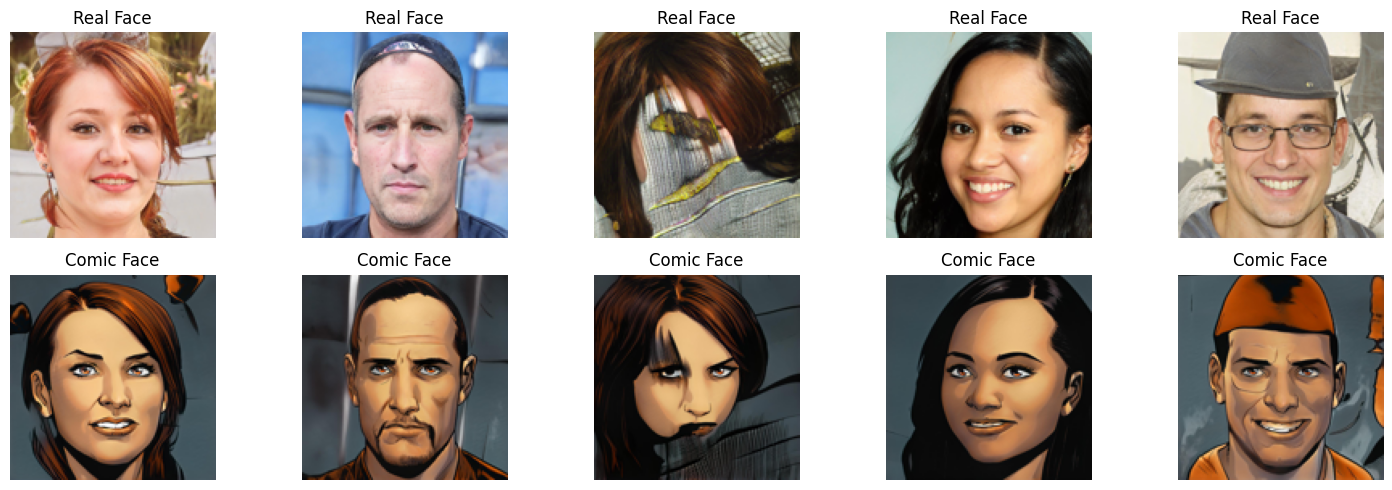

In [5]:
show_sample_pairs()

In [6]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch

In [7]:
class ComicFaceDataset(Dataset):
    def __init__(self, root_dir="dataset", image_size=256):
        self.face_dir = os.path.join(root_dir, "faces")
        self.comic_dir = os.path.join(root_dir, "comics")
        self.images = sorted(os.listdir(self.face_dir))

        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        face_path = os.path.join(self.face_dir, self.images[idx])
        comic_path = os.path.join(self.comic_dir, self.images[idx])

        face_img = Image.open(face_path).convert("RGB")
        comic_img = Image.open(comic_path).convert("RGB")

        face_tensor = self.transform(face_img)
        comic_tensor = self.transform(comic_img)

        return {"real": face_tensor, "comic": comic_tensor}

In [8]:
import torch
import torch.nn as nn

In [9]:
# Encoder block (Conv → BatchNorm → LeakyReLU)
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [10]:
# Decoder block (TransposeConv → BatchNorm → Dropout(optional) → ReLU)
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(0.5))
        self.block = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.block(x)
        return torch.cat((x, skip_input), dim=1)

In [11]:
# Full U-Net Generator
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.down1 = DownBlock(in_channels, 64, normalize=False)  # (bs, 64, 128, 128)
        self.down2 = DownBlock(64, 128)                            # (bs, 128, 64, 64)
        self.down3 = DownBlock(128, 256)                           # (bs, 256, 32, 32)
        self.down4 = DownBlock(256, 512)                           # (bs, 512, 16, 16)
        self.down5 = DownBlock(512, 512)                           # (bs, 512, 8, 8)
        self.down6 = DownBlock(512, 512)                           # (bs, 512, 4, 4)
        self.down7 = DownBlock(512, 512)                           # (bs, 512, 2, 2)
        self.down8 = DownBlock(512, 512, normalize=False)          # (bs, 512, 1, 1)

        self.up1 = UpBlock(512, 512, dropout=True)                 # (bs, 512, 2, 2)
        self.up2 = UpBlock(1024, 512, dropout=True)                # (bs, 512, 4, 4)
        self.up3 = UpBlock(1024, 512, dropout=True)                # (bs, 512, 8, 8)
        self.up4 = UpBlock(1024, 512)                              # (bs, 512, 16, 16)
        self.up5 = UpBlock(1024, 256)                              # (bs, 256, 32, 32)
        self.up6 = UpBlock(512, 128)                               # (bs, 128, 64, 64)
        self.up7 = UpBlock(256, 64)                                # (bs, 64, 128, 128)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        # Decoder + skip connections
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device}")

Using Device: cuda


In [13]:
gen = UNetGenerator().to(device)

In [14]:
x = torch.randn(1, 3, 256, 256).to(device)
y = gen(x)
print(f"Input: {x.shape}, Output: {y.shape}")

Input: torch.Size([1, 3, 256, 256]), Output: torch.Size([1, 3, 256, 256])


In [15]:
# PatchGAN Discriminator
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def block(in_c, out_c, normalize=True):
            layers = [nn.Conv2d(in_c, out_c, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(in_channels * 2, 64, normalize=False),  # Input is real + target (concatenated)
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # Output patch map
        )

    def forward(self, input_img, target_img):
        # Concatenate image and condition image by channels to produce input
        x = torch.cat((input_img, target_img), dim=1)
        return self.model(x)

In [16]:
disc = PatchDiscriminator().to(device)

In [17]:
real = torch.randn(1, 3, 256, 256).to(device)
target = torch.randn(1, 3, 256, 256).to(device)

In [18]:
output = disc(real, target)
print(f"Discriminator output shape: {output.shape}")

Discriminator output shape: torch.Size([1, 1, 15, 15])


In [19]:
import torch.nn.functional as F

In [20]:
# Loss functions
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()

In [21]:
# Initialize generator and discriminator
generator = UNetGenerator().to(device)
discriminator = PatchDiscriminator().to(device)

In [22]:
# Optimizers
lr = 2e-4
beta1, beta2 = 0.5, 0.999

In [23]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

In [24]:
def get_target_tensor(pred, is_real):
    if is_real:
        return torch.ones_like(pred, device=device)
    else:
        return torch.zeros_like(pred, device=device)


In [25]:
import time
from torch.utils.data import DataLoader
from tqdm import tqdm

In [26]:
# Hyperparameters
epochs = 100
batch_size = 4
image_size = 256
lambda_L1 = 100  # weight for L1 loss

In [27]:
# Dataloader
train_dataset = ComicFaceDataset("dataset", image_size=image_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [28]:
checkpoint_path = "checkpoint.pth"
best_model_path = "best_generator.pth"
start_epoch = 0
best_g_loss = float("inf")

In [29]:
if os.path.exists(checkpoint_path):
    print("🔁 Resuming from checkpoint...")
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    generator.load_state_dict(checkpoint["generator"])
    discriminator.load_state_dict(checkpoint["discriminator"])
    optimizer_G.load_state_dict(checkpoint["optimizer_G"])
    optimizer_D.load_state_dict(checkpoint["optimizer_D"])
    start_epoch = checkpoint["epoch"] + 1
    best_g_loss = checkpoint.get("best_g_loss", best_g_loss)
    print(f"✅ Resumed from epoch {start_epoch}")

🔁 Resuming from checkpoint...
✅ Resumed from epoch 100


In [30]:
# === Start Training Loop ===
try:
    for epoch in range(start_epoch, epochs):
        start_time = time.time()
        g_loss_total, d_loss_total = 0, 0

        print(f"\nEpoch [{epoch+1}/{epochs}]")
        progress_bar = tqdm(train_loader, desc="Training", leave=False)

        for batch in progress_bar:
            real_face = batch["real"].to(device)
            comic_face = batch["comic"].to(device)

            # --- Train Discriminator ---
            optimizer_D.zero_grad()
            pred_real = discriminator(real_face, comic_face)
            loss_real = criterion_GAN(pred_real, get_target_tensor(pred_real, True))

            fake_comic = generator(real_face)
            pred_fake = discriminator(real_face, fake_comic.detach())
            loss_fake = criterion_GAN(pred_fake, get_target_tensor(pred_fake, False))

            loss_D = (loss_real + loss_fake) * 0.5
            loss_D.backward()
            optimizer_D.step()

            # --- Train Generator ---
            optimizer_G.zero_grad()
            pred_fake = discriminator(real_face, fake_comic)
            loss_G_GAN = criterion_GAN(pred_fake, get_target_tensor(pred_fake, True))
            loss_G_L1 = criterion_L1(fake_comic, comic_face) * lambda_L1
            loss_G = loss_G_GAN + loss_G_L1

            loss_G.backward()
            optimizer_G.step()

            # Logging
            g_loss_total += loss_G.item()
            d_loss_total += loss_D.item()
            progress_bar.set_postfix({
                "G_Loss": f"{loss_G.item():.4f}",
                "D_Loss": f"{loss_D.item():.4f}"
            })

        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{epochs}] ✅ G_Loss: {g_loss_total:.4f} | D_Loss: {d_loss_total:.4f} | ⏱️ {epoch_time:.2f}s")

        # === Save checkpoint every epoch ===
        torch.save({
            "epoch": epoch,
            "generator": generator.state_dict(),
            "discriminator": discriminator.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict(),
            "best_g_loss": best_g_loss
        }, checkpoint_path)

        # === Save best generator ===
        if g_loss_total < best_g_loss:
            best_g_loss = g_loss_total
            torch.save(generator.state_dict(), best_model_path)
            print("🌟 Best generator model saved!")

except KeyboardInterrupt:
    print("\n🛑 Training interrupted! Saving checkpoint...")
    torch.save({
        "epoch": epoch,
        "generator": generator.state_dict(),
        "discriminator": discriminator.state_dict(),
        "optimizer_G": optimizer_G.state_dict(),
        "optimizer_D": optimizer_D.state_dict(),
        "best_g_loss": best_g_loss
    }, checkpoint_path)
    print("✅ Checkpoint saved. You can resume later.")

In [31]:
def visualize_sample(real_face, comic_face, generated_comic):
    real_face = real_face.cpu().permute(1, 2, 0).detach().numpy()
    comic_face = comic_face.cpu().permute(1, 2, 0).detach().numpy()
    generated_comic = generated_comic.cpu().permute(1, 2, 0).detach().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    titles = ["Input (Real Face)", "Ground Truth (Comic)", "Generated Comic"]

    for ax, img, title in zip(axes, [real_face, comic_face, generated_comic], titles):
        ax.imshow((img * 0.5) + 0.5)  # Denormalize
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [32]:
# Switch to eval mode
generator.eval()

UNetGenerator(
  (down1): DownBlock(
    (block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down2): DownBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down3): DownBlock(
    (block): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down4): DownBlock(
    (block): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affin

In [33]:
# Get one batch
sample = next(iter(train_loader))
real = sample["real"].to(device)
comic = sample["comic"].to(device)

In [34]:
# Generate output
with torch.no_grad():
    generated = generator(real)

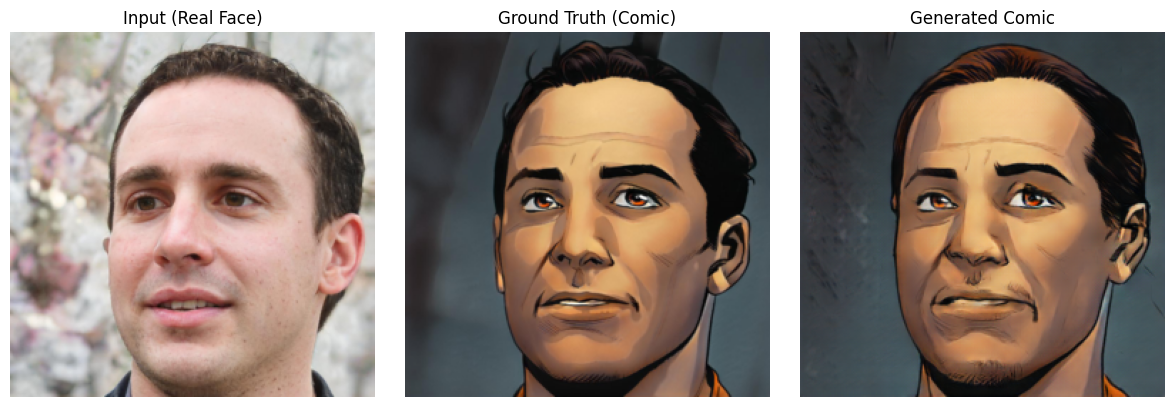

In [35]:
# Visualize one image from batch
visualize_sample(real[0], comic[0], generated[0])

In [36]:
# Save generator and discriminator
torch.save(generator.state_dict(), "generator_pix2pix.pth")
torch.save(discriminator.state_dict(), "discriminator_pix2pix.pth")
print("✅ Models saved successfully!")

✅ Models saved successfully!


In [37]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [38]:
# Recreate model structure and load weights
generator = UNetGenerator().to(device)
generator.load_state_dict(torch.load("generator_pix2pix.pth", map_location=device))
generator.eval()

C:\Users\gujar\AppData\Local\Temp\ipykernel_8148\374397681.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator_pix2pix.pth", 

UNetGenerator(
  (down1): DownBlock(
    (block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down2): DownBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down3): DownBlock(
    (block): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down4): DownBlock(
    (block): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affin

In [39]:
# Same transforms used during training
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])


In [40]:
img_path = "image4.jpg"  # 👈 Your input real face image
image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)  # [1, 3, 256, 256]

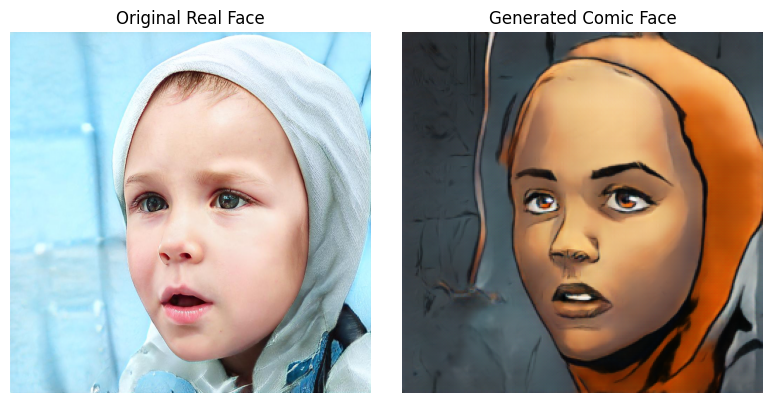

In [41]:
with torch.no_grad():
    generated = generator(input_tensor)

# Denormalize for viewing
generated_img = generated[0].cpu().permute(1, 2, 0)
generated_img = (generated_img * 0.5) + 0.5  # Back to [0, 1]

# Show original and cartoon
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Real Face")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(generated_img)
plt.title("Generated Comic Face")
plt.axis("off")

plt.tight_layout()
plt.show()